In [15]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata


In [3]:
def sabr_vol(alpha, beta, rho, nu, F, K, T):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        output = alpha*(1 + (numer1 + ((nu*alpha*beta)/F**(1-beta) + (2-3*rho*rho)*nu*nu/24)*T)/(1+T))
    else:
        z = nu/alpha*(F*X)**((1-beta)/2)*np.log(F/X)
        x = np.log((np.sqrt(1 - 2*rho*z + z*z) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1-beta)))
        numer2 = 1 + (((1 - beta)**2/4)*np.log(F/X)*np.log(F/X)) + (((1 - beta)**4/1920)*np.log(F/X)*np.log(F/X)*np.log(F/X)*np.log(F/X))
        output = alpha*(z/x)*(1 + (numer1 + numer2*T)/(1+T))
    return output

def calibration_error(params, F, K, T, vol):
    alpha, beta, rho, nu = params
    vol_hat = sabr_vol(alpha, beta, rho, nu, F, K, T)
    return np.sum((vol - vol_hat)**2)

In [ ]:
ticker = input("Enter the ticker of the stock you want to analyze: ").upper()
# try:
stock = yf.Ticker(ticker)
expirations = stock.options
if not expirations:
    raise ValueError("No options available for this stock")
else:
    print("Available expirations: ", expirations)
    chosen_expiration = input("Enter the expiration date you want to analyze: ")
    if chosen_expiration not in expirations:
        raise ValueError("Invalid expiration date")
    options_chain = stock.option_chain(chosen_expiration)
    calls = options_chain.calls
    puts = options_chain.puts
    calls = calls[calls["volume"] > 0]
    puts = puts[puts["volume"] > 0]
    calls = calls[calls["openInterest"] > 0]
    puts = puts[puts["openInterest"] > 0]
    calls = calls[calls["strike"] > calls["lastPrice"]]
    puts = puts[puts["strike"] < puts["lastPrice"]]
    calls = calls.sort_values(by="strike")
    puts = puts.sort_values(by="strike")
    calls = calls.reset_index(drop=True)
    puts = puts.reset_index(drop=True)
    F = stock.history(period="1d")["Close"][-1]
    K = calls["strike"]
    T = (pd.to_datetime(chosen_expiration) - pd.Timestamp.today()).days/365
    call_vol = calls["impliedVolatility"]
    put_vol = puts["impliedVolatility"]
    K = K.to_numpy()
    call_vol = call_vol.to_numpy()
    put_vol = put_vol.to_numpy()
    call_params = minimize(calibration_error, [0.1, 0.5, 0, 0.1], args=(F, K, T, call_vol)).x
    put_params = minimize(calibration_error, [0.1, 0.5, 0, 0.1], args=(F, K, T, put_vol)).x
    K = np.append(K, F)
    call_vol = np.append(call_vol, sabr_vol(call_params[0], call_params[1], call_params[2], call_params[3], F, F, T))
    put_vol = np.append(put_vol, sabr_vol(put_params[0], put_params[1], put_params[2], put_params[3], F, F, T))
    plt.plot(K, call_vol, label="Call Volatility")
    plt.plot(K, put_vol, label="Put Volatility")
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.show()
# except:



Available expirations:  ('2025-01-03', '2025-01-10', '2025-01-17', '2025-01-24', '2025-01-31', '2025-02-07', '2025-02-21', '2025-03-21', '2025-04-17', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18', '2027-01-15')


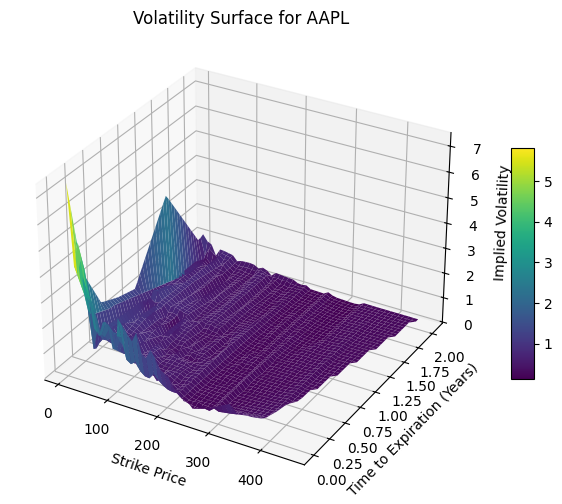

In [16]:
# Plot vol surface

def calculate_time_to_expiration(expiration_date):
    return (pd.to_datetime(expiration_date) - pd.Timestamp.today()).days / 365.0

ticker = input("Enter the ticker of the stock you want to analyze: ").upper()
# try:
stock = yf.Ticker(ticker)
expirations = stock.options
if not expirations:
    raise ValueError("No options available for this stock")
else:
    print("Available expirations: ", expirations)

vol_data = []
strike_data = []
time_data = []

for expiration in expirations:
    options_chain = stock.option_chain(expiration)
    calls = options_chain.calls
    puts = options_chain.puts

    # Filter out rows with missing data or invalid strikes
    calls = calls[(calls["volume"] > 0) & (calls["openInterest"] > 0)]
    puts = puts[(puts["volume"] > 0) & (puts["openInterest"] > 0)]

    # Combine calls and puts
    options = pd.concat([calls, puts])
    options = options[options["impliedVolatility"] > 0]

    if not options.empty:
        strikes = options["strike"].to_numpy()
        volatilities = options["impliedVolatility"].to_numpy()
        time_to_exp = np.full_like(strikes, calculate_time_to_expiration(expiration))

        # Append to data
        strike_data.extend(strikes)
        vol_data.extend(volatilities)
        time_data.extend(time_to_exp)

# Convert to numpy arrays
strike_data = np.array(strike_data)
vol_data = np.array(vol_data)
time_data = np.array(time_data)

# Create a grid for the surface
strike_range = np.linspace(strike_data.min(), strike_data.max(), 50)
time_range = np.linspace(time_data.min(), time_data.max(), 50)
strike_grid, time_grid = np.meshgrid(strike_range, time_range)

# Interpolate volatilities on the grid
vol_surface = griddata(
    (strike_data, time_data), vol_data, (strike_grid, time_grid), method='linear'
)

# Plot the volatility surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(strike_grid, time_grid, vol_surface, cmap='viridis', edgecolor='none')

# Add labels and title
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Expiration (Years)')
ax.set_zlabel('Implied Volatility')
ax.set_title(f'Volatility Surface for {ticker}')
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()
